In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Using TensorFlow backend


/var/folders/89/zwv576xj2cggljymv3ln02780000gn/T/ipykernel_10328/2855838412.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Load data
# Example: Assuming you have a CSV file with 'date' and 'layoffs' columns
data = pd.read_csv('/Users/asaifali/Downloads/layoffs_data(2).csv')
data

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Farfetch,London,Retail,0.25,2024-02-16,https://ominho.pt/depois-da-saida-do-ceo-de-gu...,1700.0,Acquired,2024-02-16 18:39:00,United Kingdom,NaN,Unknown
1,Toast,Boston,Food,0.10,2024-02-15,https://www.bloomberg.com/news/articles/2024-0...,962.0,Post-IPO,2024-02-15 16:48:04,United States,550.0,Unknown
2,Storytel,Stockholm,Consumer,0.13,2024-02-15,https://investors.storytel.com/en/wp-content/u...,312.0,Post-IPO,2024-02-16 18:37:24,Sweden,80.0,Unknown
3,Gro Intelligence,New York City,Food,0.10,2024-02-15,https://agfundernews.com/ai-powered-ag-insight...,118.0,Series B,2024-02-16 18:35:19,United States,20.0,Unknown
4,CodeSee,SF Bay Area,Data,1.00,2024-02-15,https://www.linkedin.com/posts/shaneak_i-am-ve...,10.0,Seed,2024-02-15 19:34:43,United States,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Service,Los Angeles,Travel,1.00,2020-03-16,https://techcrunch.com/2020/03/16/travel-savin...,5.1,Seed,2020-08-31 15:17:26,United States,NaN,Unknown
3450,HopSkipDrive,Los Angeles,Transportation,0.10,2020-03-13,https://layoffs.fyi/2020/04/02/hopskipdrive-la...,45.0,Unknown,2020-04-03 04:47:03,United States,8.0,Unknown
3451,Panda Squad,SF Bay Area,Consumer,0.75,2020-03-13,https://twitter.com/danielsinger/status/123854...,1.0,Seed,2020-04-17 00:12:49,United States,6.0,Unknown
3452,Tamara Mellon,Los Angeles,Retail,0.40,2020-03-12,https://layoffs.fyi/list/tamara-mellon/,90.0,Series C,2020-03-31 16:04:23,United States,20.0,Unknown


In [3]:
# Preprocess data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.isnull().sum()

Company                          0
Location_HQ                      0
Industry                         0
Percentage                    1228
Source                           0
Funds_Raised                   366
Stage                            0
Date_Added                       0
Country                          0
Laid_Off_Count                1185
List_of_Employees_Laid_Off       1
dtype: int64

In [5]:
data.dropna(subset=['Laid_Off_Count'], inplace=True)

In [6]:
# Drop columns
columns_to_drop = ['Percentage','List_of_Employees_Laid_Off','Company','Source','Date_Added']  # List of column names to drop
data.drop(columns=columns_to_drop, inplace=True)

In [7]:
data

,Location_HQ,Industry,Funds_Raised,Stage,Country,Laid_Off_Count
Date,,,,,,
2024-02-15,Boston,Food,962.0,Post-IPO,United States,550.0
2024-02-15,Stockholm,Consumer,312.0,Post-IPO,Sweden,80.0
2024-02-15,New York City,Food,118.0,Series B,United States,20.0
2024-02-14,SF Bay Area,Infrastructure,2.0,Post-IPO,United States,4250.0
2024-02-14,Nashik,Finance,16.0,Series A,India,19.0
...,...,...,...,...,...,...
2020-03-16,Austin,Support,6.0,Seed,United States,16.0
2020-03-13,Los Angeles,Transportation,45.0,Unknown,United States,8.0
2020-03-13,SF Bay Area,Consumer,1.0,Seed,United States,6.0


In [8]:
data.dropna(subset=['Funds_Raised'], inplace=True)

In [9]:
data.isnull().sum()

Location_HQ       0
Industry          0
Funds_Raised      0
Stage             0
Country           0
Laid_Off_Count    0
dtype: int64

In [10]:
# Label Encoding
label_encoder = LabelEncoder()
data = data.copy()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

print("Label Encoded Data:")
print(data)


Label Encoded Data:
            Location_HQ  Industry  Funds_Raised  Stage  Country  \
Date                                                              
2024-02-15           20        10         962.0      1       45   
2024-02-15          140         3         312.0      1       39   
2024-02-15          104        10         118.0      5       45   
2024-02-14          121        14           2.0      1       45   
2024-02-14           99         8          16.0      4       17   
...                 ...       ...           ...    ...      ...   
2020-03-16            6        27           6.0      3       45   
2020-03-13           84        28          45.0     15       45   
2020-03-13          121         3           1.0      3       45   
2020-03-12           84        24          90.0      6       45   
2020-03-11          123        16          12.0      4       45   

            Laid_Off_Count  
Date                        
2024-02-15           550.0  
2024-02-15           

In [11]:
data

,Location_HQ,Industry,Funds_Raised,Stage,Country,Laid_Off_Count
Date,,,,,,
2024-02-15,20,10,962.0,1,45,550.0
2024-02-15,140,3,312.0,1,39,80.0
2024-02-15,104,10,118.0,5,45,20.0
2024-02-14,121,14,2.0,1,45,4250.0
2024-02-14,99,8,16.0,4,17,19.0
...,...,...,...,...,...,...
2020-03-16,6,27,6.0,3,45,16.0
2020-03-13,84,28,45.0,15,45,8.0
2020-03-13,121,3,1.0,3,45,6.0


In [12]:
# Assuming 'data' contains your dataset with appropriate columns and datetime index

# Define the target variable
target_variable = 'Laid_Off_Count'

# Define the exogenous variables
exogenous_variables = ['Funds_Raised', 'Location_HQ', 'Industry', 'Stage', 'Country']

# Combine the target variable and exogenous variables into one DataFrame
data_selected = data[[target_variable] + exogenous_variables]

# Fill any missing values or handle them appropriately
data_selected.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Split the data into training and testing sets
train_size = int(len(data_selected) * 0.8)  # 80% train, 20% test
train_data, test_data = data_selected.iloc[:train_size], data_selected.iloc[train_size:]

# Extract features (exogenous variables) and target variable for training and testing sets
X_train = train_data[exogenous_variables].values.reshape(-1, 1, len(exogenous_variables))
y_train = train_data[target_variable].values
X_test = test_data[exogenous_variables].values.reshape(-1, 1, len(exogenous_variables))
y_test = test_data[target_variable].values


In [13]:
# Create MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize training data
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Normalize testing data using the same scaler
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Normalize y_train and y_test if needed
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_test = scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)


In [14]:
# Define the model-building function with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'),
                             input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(BatchNormalization())
    for i in range(hp.Int('num_layers', min_value=0, max_value=2)):
        model.add(Dense(units=hp.Int(f'dense_units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dense_dropout_rate_{i}', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(BatchNormalization())
    model.add(Dense(6))
    model.compile(optimizer='adam', loss='mse')
    return model



In [15]:
# Instantiate the RandomSearch tuner with a different directory
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=3,
    directory='/Users/asaifali/Desktop/TSF/my_dir',  # Specify a directory where you have write permissions
    project_name='layoffs_prediction'
)


In [16]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [17]:
# Perform the hyperparameter search with callbacks
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
              callbacks=[EarlyStopping(patience=3), reduce_lr])

Trial 5 Complete [00h 00m 10s]
val_loss: 0.0008559290242070953

Best val_loss So Far: 0.0008429138688370585
Total elapsed time: 00h 00m 47s


In [18]:
# Retrieve the best model configuration
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

In [19]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 384)              229248    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)                 2310      
                                                                 
Total params: 233,094
Trainable params: 232,326
Non-trainable params: 768
_________________________________________________________________


In [32]:
# Train the model
history = best_model.fit(X_train, y_train, epochs=33, validation_split=0.2, callbacks=[EarlyStopping(patience=19), reduce_lr])


Epoch 1/33
42/42 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0041 - lr: 0.0010
Epoch 2/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0039 - lr: 0.0010
Epoch 3/33
42/42 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0018 - lr: 0.0010
Epoch 4/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0015 - lr: 0.0010
Epoch 6/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0022 - lr: 0.0010
Epoch 7/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/33
42/42 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/33
42/42 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0011 - lr: 0.0010
E

In [33]:
# Evaluate the model
mse = best_model.evaluate(X_test, y_test)
print("Test MSE:", mse)

13/13 [==============================] - 0s 1ms/step - loss: 8.4961e-04
Test MSE: 0.0008496064692735672


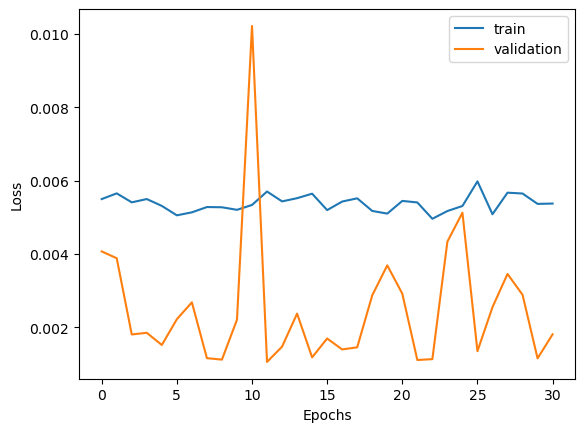

In [34]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Make predictions
predictions = best_model.predict(X_test)

 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 2ms/step


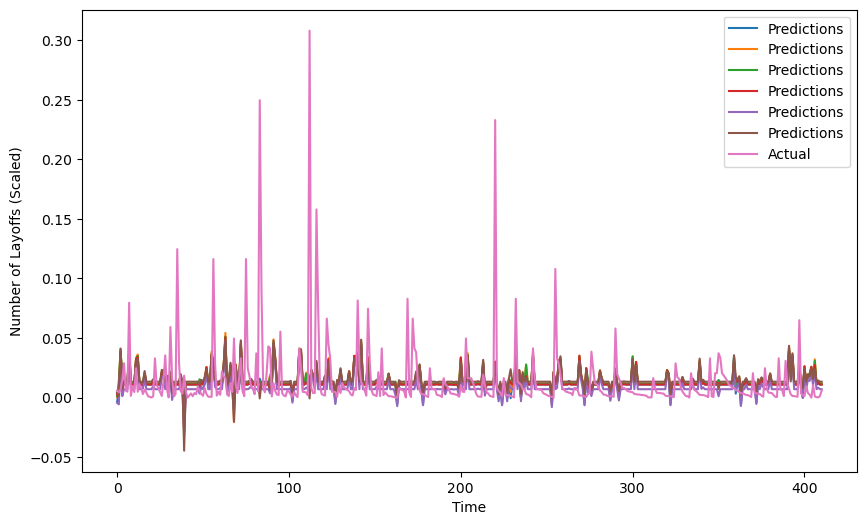

In [36]:
# Visualize predictions with larger figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
plt.plot(predictions, label='Predictions')
plt.plot(y_test, label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Layoffs (Scaled)')
plt.legend()
plt.show()


In [37]:
# Reshape y_test to match the shape of predictions
y_test_reshaped = np.repeat(y_test.reshape(-1, 1), 6, axis=1)

# Calculate Mean Squared Error (MSE) for each dimension separately
mse = mean_squared_error(y_test_reshaped, predictions, multioutput='raw_values')

# Compute overall MSE as the mean of MSEs for each dimension
overall_mse = np.mean(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_reshaped, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, predictions))

# Calculate R-squared (R^2) score
r2 = r2_score(y_test_reshaped, predictions)

print("Mean Squared Error (MSE) for each dimension:", mse)
print("Overall Mean Squared Error (MSE):", overall_mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2) Score:", r2)


Mean Squared Error (MSE) for each dimension: [0.00081953 0.00084553 0.00083493 0.00085305 0.0008544  0.0008902 ]
Overall Mean Squared Error (MSE): 0.0008496064217690563
Mean Absolute Error (MAE): 0.014465861956775303
Root Mean Squared Error (RMSE): 0.029148008881723916
R-squared (R^2) Score: 0.0014066535141471863
